# Modelling Parkrun

## Best models and evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import scipy.stats as stats

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [29]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

random_state = 42
cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

In [30]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [4]:
athlete_data = '../../../../../capstone_data/data_all/athlete_dict.csv'
event_data = '../../../../../capstone_data/data_all/event_dict.csv'
eda_data_02_filename = '../../../../../capstone_data/data_all/eda_data_02.csv'

In [5]:
data = pd.read_csv(eda_data_02_filename, index_col=0, parse_dates=['date'], dayfirst=True)

/Applications/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
data.columns

Index(['event_index', 'event_no', 'date', 'positions', 'athlete_no',
       'total_parkruns', 'run_time', 'event_PB', 'in_club', 'age_groups',
       'age_grades', 'is_PB', 'month', 'count_finishers', 'season',
       'med_course_time', 'med_event_time'],
      dtype='object')

In [7]:
# select features for modelling
regression_cols = ['event_index', 'positions',
       'total_parkruns', 'event_PB', 'in_club', 'age_groups',
       'month', 'count_finishers', 'season',
       'med_course_time']
regression_cat_cols = ['event_index','in_club', 'age_groups', 'month', 'season']
regression_excluded = ['event_no', 'date', 'athlete_no', 'age_grades', 'is_PB', 'med_event_time']
target_col = ['run_time']

In [8]:
# Apply transformations
X = data[['event_index','total_parkruns', 'in_club', 'age_groups',
         'month', 'count_finishers', 'season', 'med_course_time']].copy()
X['log_positions'] = np.log(data.positions)
X['log_event_PB'] = np.log(data.event_PB)
y = np.log(data.run_time)

In [9]:
# Dummify categorical features
X = pd.get_dummies(X, columns=regression_cat_cols, drop_first=True)

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state)

In [11]:
# Standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

## Decision Tree Regressor

In [12]:
dtree = DecisionTreeRegressor(max_depth=100)

dtree_scores = cross_val_score(dtree, X_train, y_train, cv=cv, n_jobs=2)
print("Cross-validated training scores:", dtree_scores)
print("Mean cross-validated training score:", dtree_scores.mean())
# fit and evaluate the data on the whole training set
dtree.fit(X_train, y_train)
print("Training Score:", dtree.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", dtree.score(X_test, y_test))

# Get predictions and calculate errors
predictions = dtree.predict(X_test)
print('MSE:', mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))
print('MAE:', mean_absolute_error(y_test, predictions))

Cross-validated training scores: [0.94923699 0.95068045 0.9497862  0.94994444 0.94984409]
Mean cross-validated training score: 0.9498984346972467
Training Score: 0.9999956460805439
Test Score: 0.9523585735044486
MSE: 0.0021440019690489994
RMSE: 0.04630336887364676
MAE: 0.02331462605861848


In [13]:
# Extract feature importances
dtree_feat = pd.DataFrame(dtree.feature_importances_, index=X_train.columns,
                       columns=['feature_importances'])

dtree_feat.sort_values('feature_importances', ascending=False).head(20)

,feature_importances
log_event_PB,0.756628
log_positions,0.119018
count_finishers,0.073288
med_course_time,0.022406
total_parkruns,0.011083
month_2,0.000597
month_12,0.000571
in_club_1.0,0.000544
season_3,0.000496
event_index_23.0,0.000488


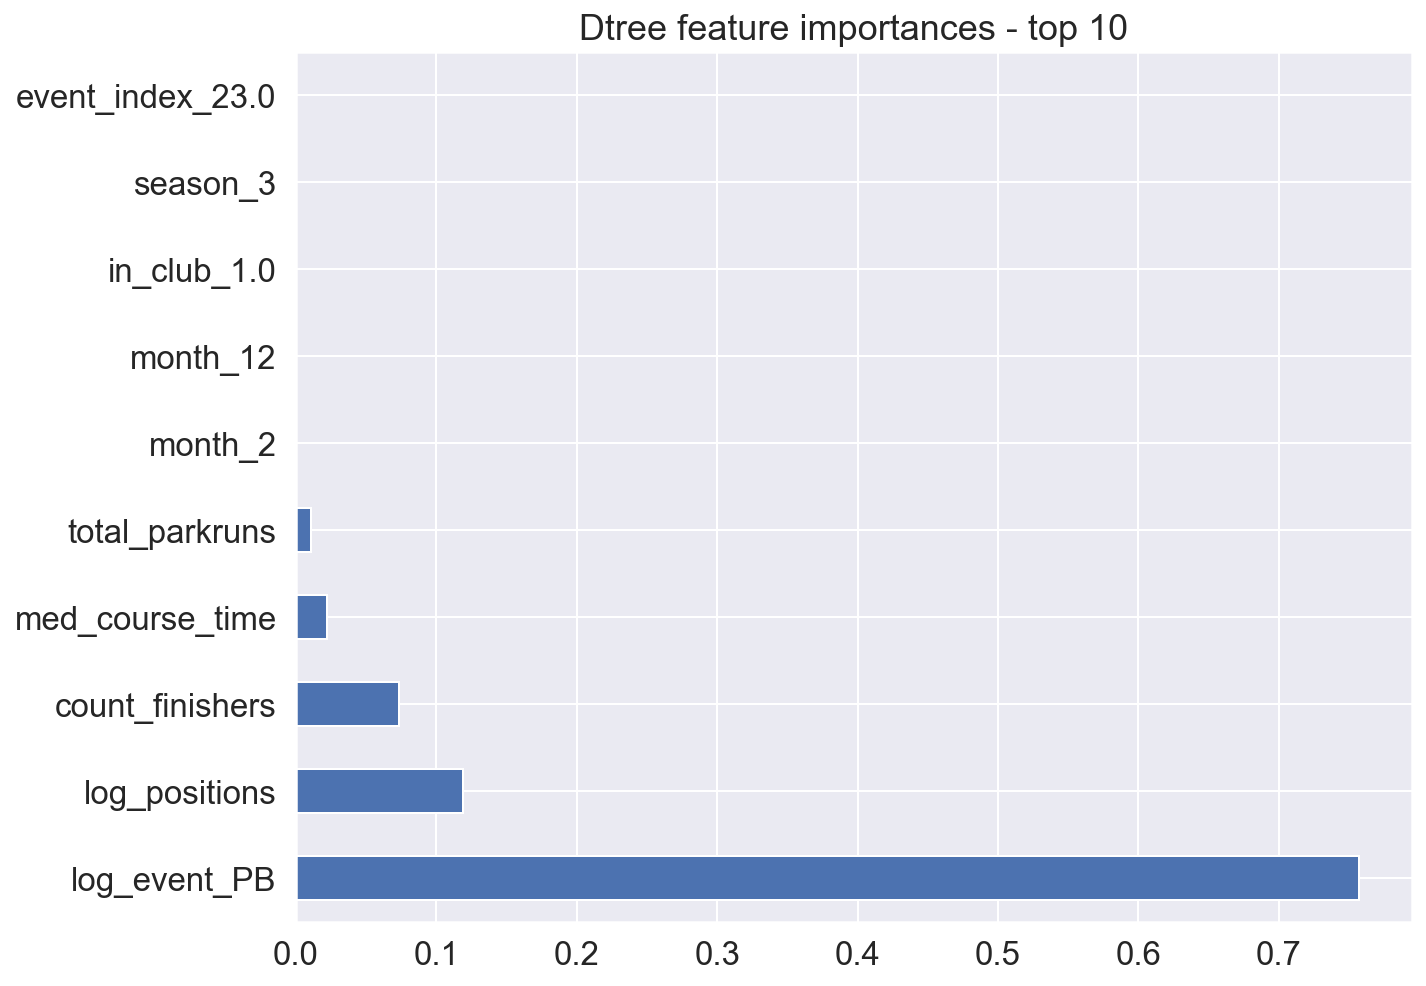

In [14]:
# plot the feature importances
plt.figure(figsize=(10,8))
plt.title('Dtree feature importances - top 10')
dtree_feat.feature_importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.show()

In [21]:
# reverse transform to evaluate predictions
preds_real = np.exp(predictions)
y_real = np.exp(y_test)
print('Test score after inverse transfrom:', r2_score(y_real, preds_real))

Test score after inverse transfrom: 0.9180179308786818


In [22]:
# Check residuals
residuals = y_real - preds_real

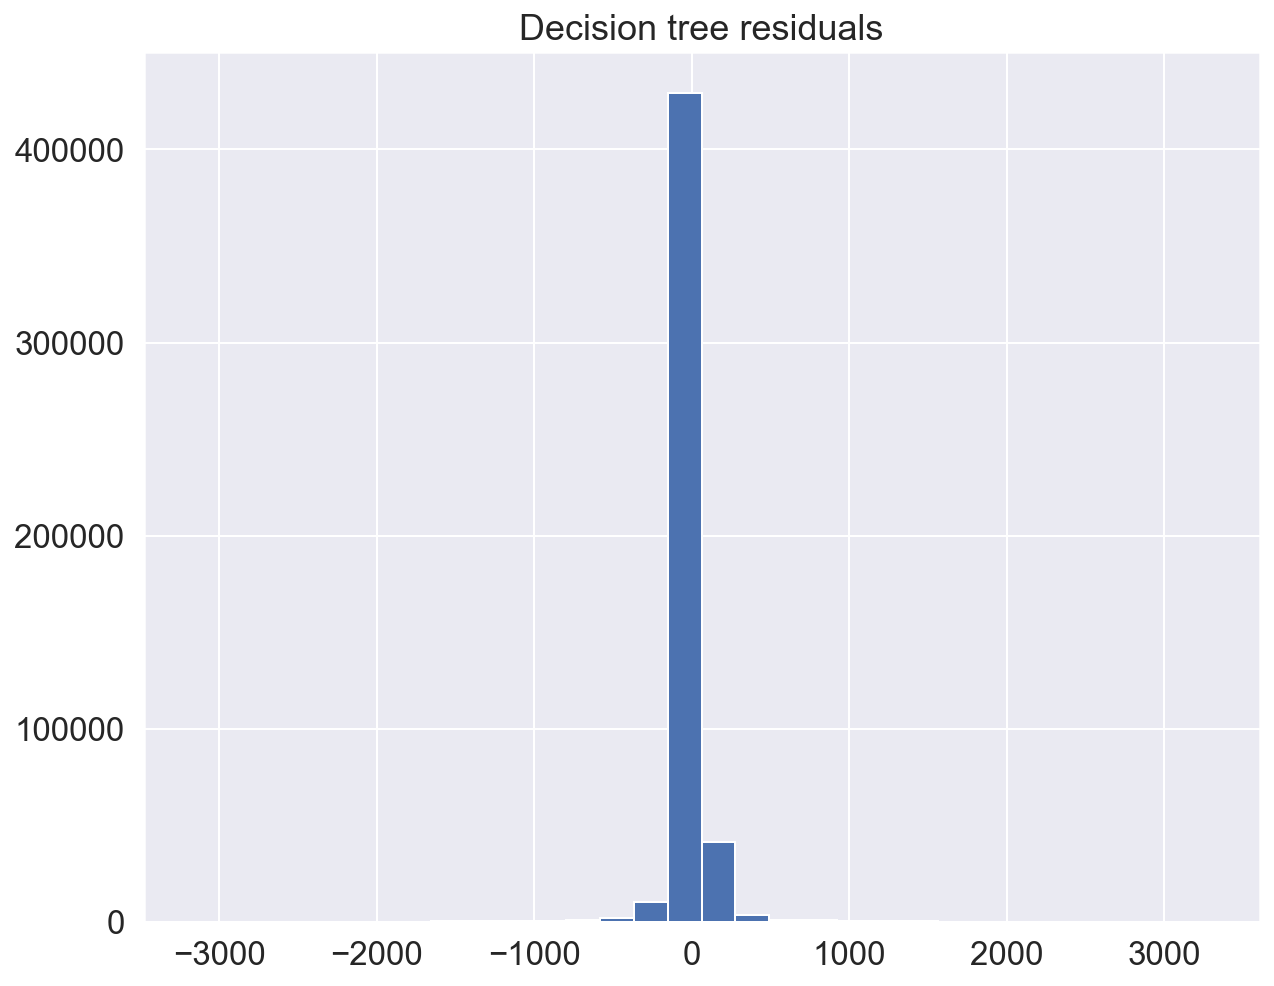

In [23]:
plt.figure(figsize=(10,8))
plt.title('Decision tree residuals')
plt.hist(residuals, bins=30)
plt.show()

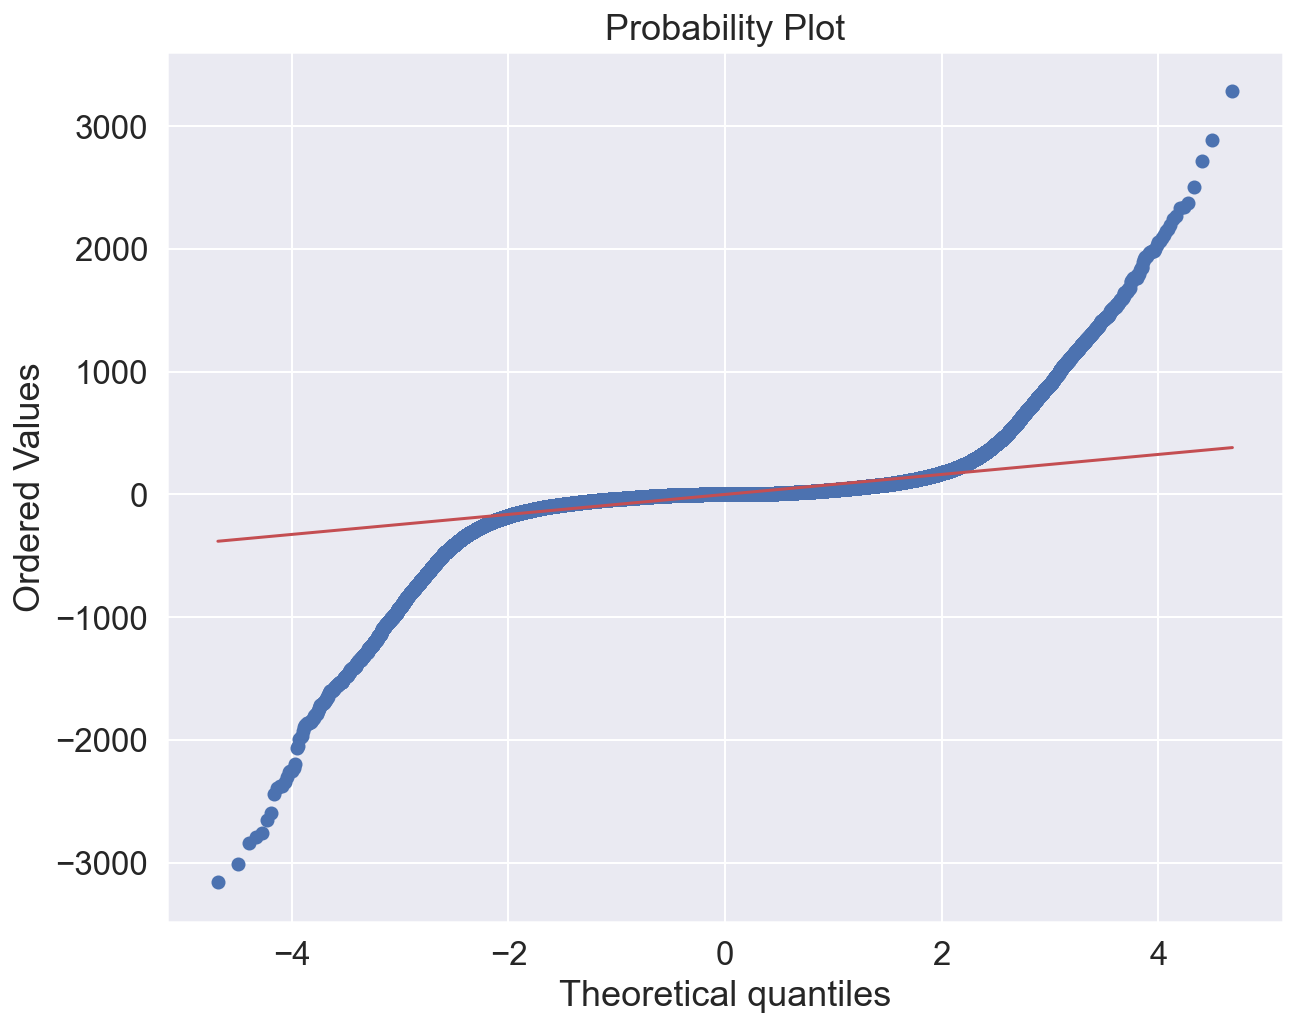

In [24]:
plt.figure(figsize=(10,8))
stats.probplot(residuals, plot=plt)
plt.show()

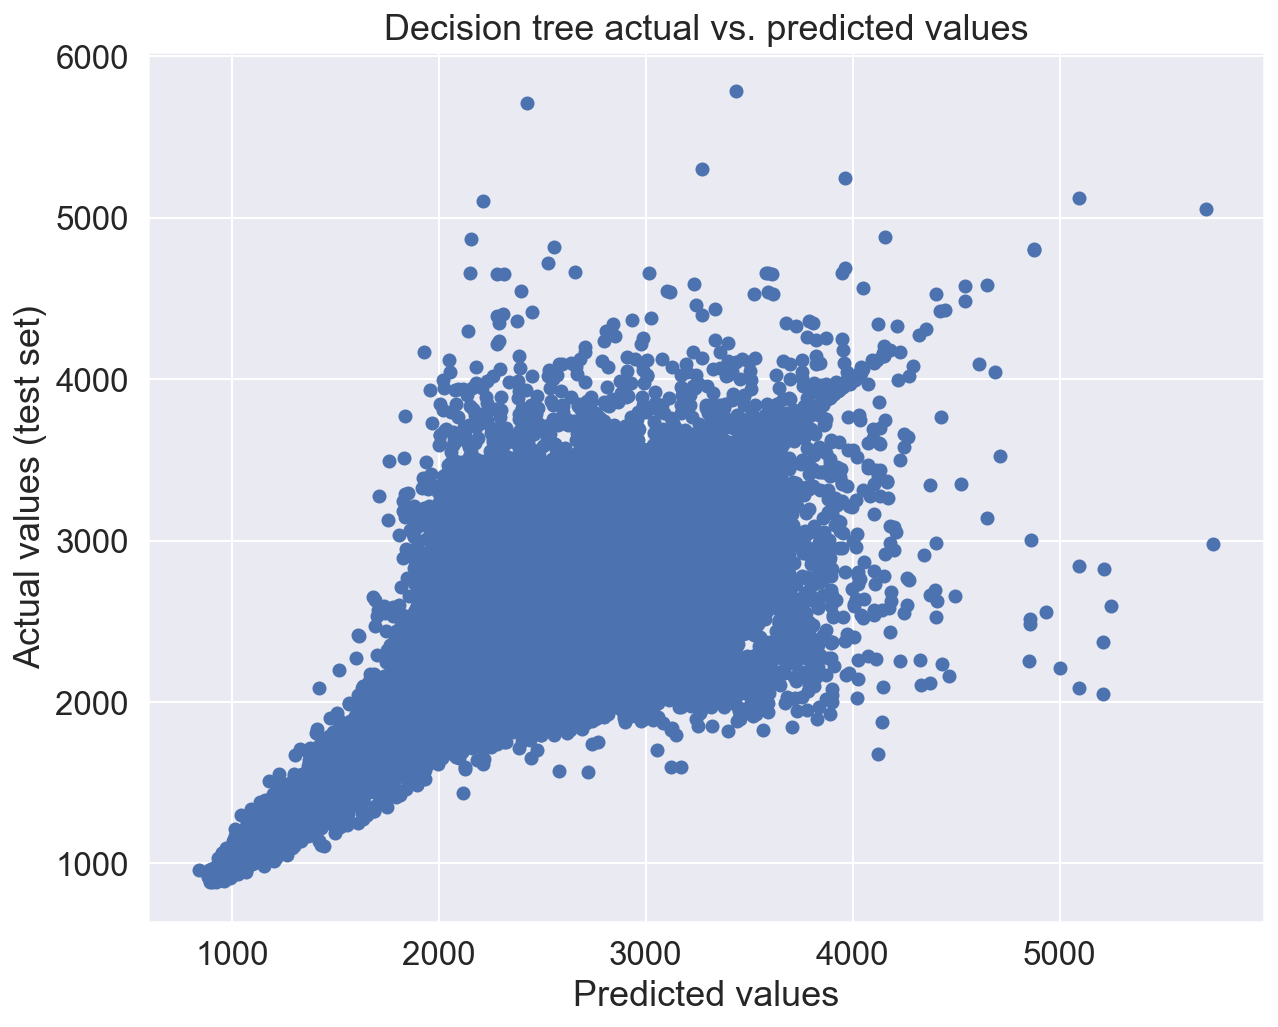

In [25]:
plt.figure(figsize=(10,8))
plt.scatter(x=preds_real, y=y_real)
plt.title('Decision tree actual vs. predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Actual values (test set)')
plt.show()

## Decision Tree Evaluation

- The scores appear to be very high but the predictions reveal that the model is performing poorly away from the mean, so the fastest and slowest times are not accurately predictied.

- Using ensemble models will help to capture the behavious in these regions.

## Histogram-based Gradient Boosting Regressor

- Similar to LightGBM this model offers performance improvement over standard Gradient Boosting with minimal loss of accuracy.
- A monotonic constraint parameter will be used to ensure that run_time increases monotonically with positions.

In [27]:
# Prepare array for monotonic contraint on positions
mono_con = np.zeros(len(X_train.columns), dtype=int)
mono_con[3] = 1

In [28]:
hgb = HistGradientBoostingRegressor(
    max_iter=500,
    max_depth=5,
    learning_rate=0.1,
    random_state=random_state,
    validation_fraction=0.1,
    n_iter_no_change=20,
    monotonic_cst=mono_con)

hgb.fit(X_train, y_train)

print('Training score:', hgb.score(X_train, y_train))
print('Test score:', hgb.score(X_test, y_test))
hgb_scores = cross_val_score(hgb, X_train, y_train, cv=cv, n_jobs=2)
print('Mean CV score:', np.mean(hgb_scores))
print('CV scores:', hgb_scores)

hgb_preds = hgb.predict(X_test)
print('MSE:', mean_squared_error(y_test, hgb_preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, hgb_preds)))
print('MAE:', mean_absolute_error(y_test, hgb_preds))

Training score: 0.9687785163383152
Test score: 0.9681404893999012
Mean CV score: 0.9676470625388902
CV scores: [0.96742859 0.96762703 0.96777035 0.96753842 0.96787092]
MSE: 0.001433770113200276
RMSE: 0.03786515698105946
MAE: 0.023187806870389325


In [50]:
# reverse transform to evaluate predictions
preds_real = np.exp(hgb_preds)
y_real = np.exp(y_test)
print('Test score after inverse transform:', r2_score(y_real, preds_real))
print('MSE:', mean_squared_error(y_real, preds_real))
print('RMSE:', np.sqrt(mean_squared_error(y_real, preds_real)))
print('MAE:', mean_absolute_error(y_real, preds_real))

Test score after inverse transform: 0.9448482560570812
MSE: 8179.161891804753
RMSE: 90.43871898586774
MAE: 43.88757277196714


In [32]:
# Check residuals
residuals = y_real - preds_real

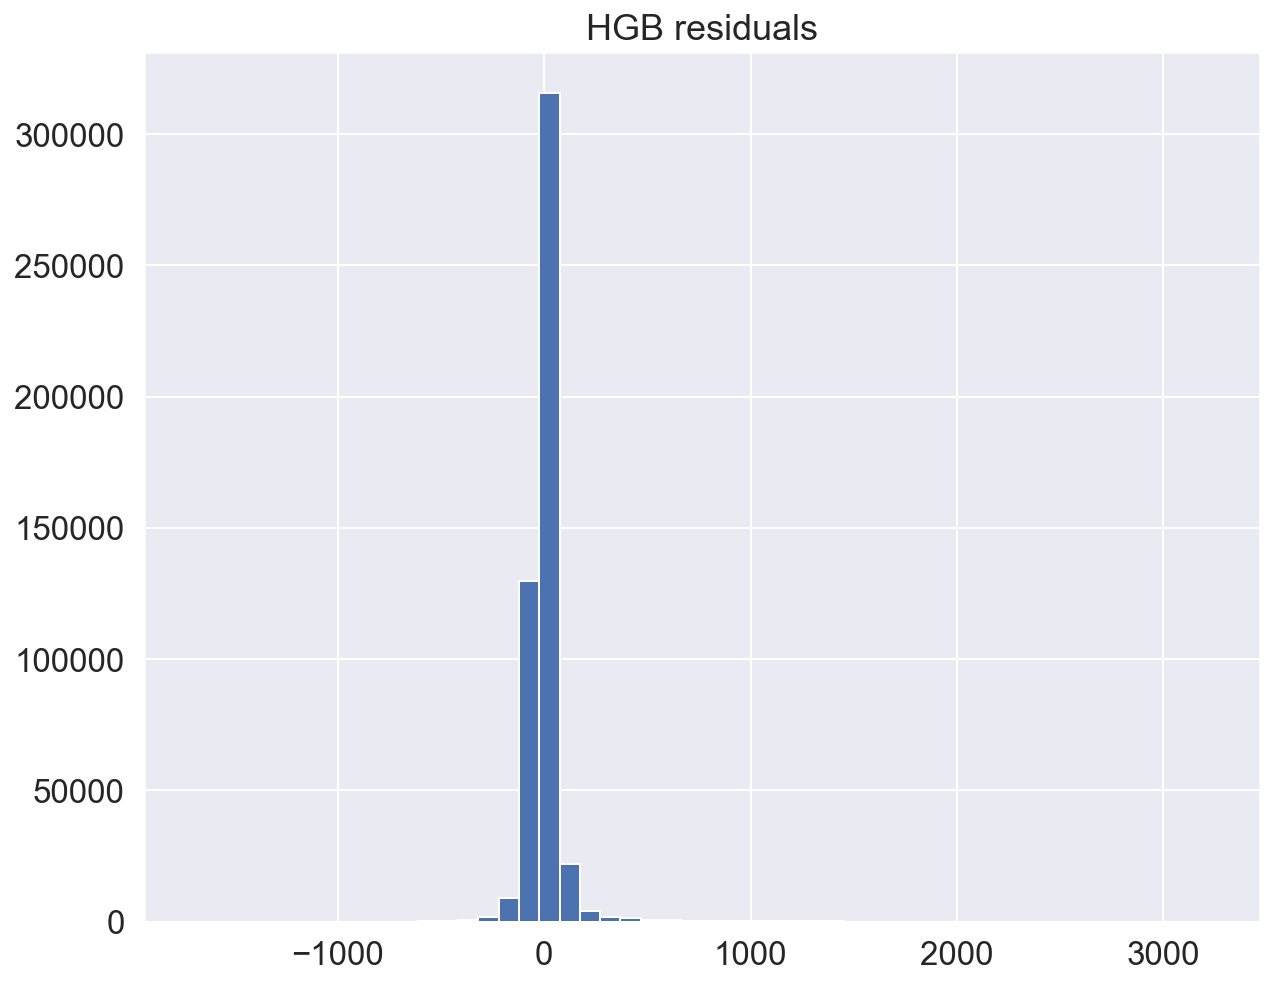

In [34]:
plt.figure(figsize=(10,8))
plt.title('HGB residuals')
plt.hist(residuals, bins=50)
plt.show()

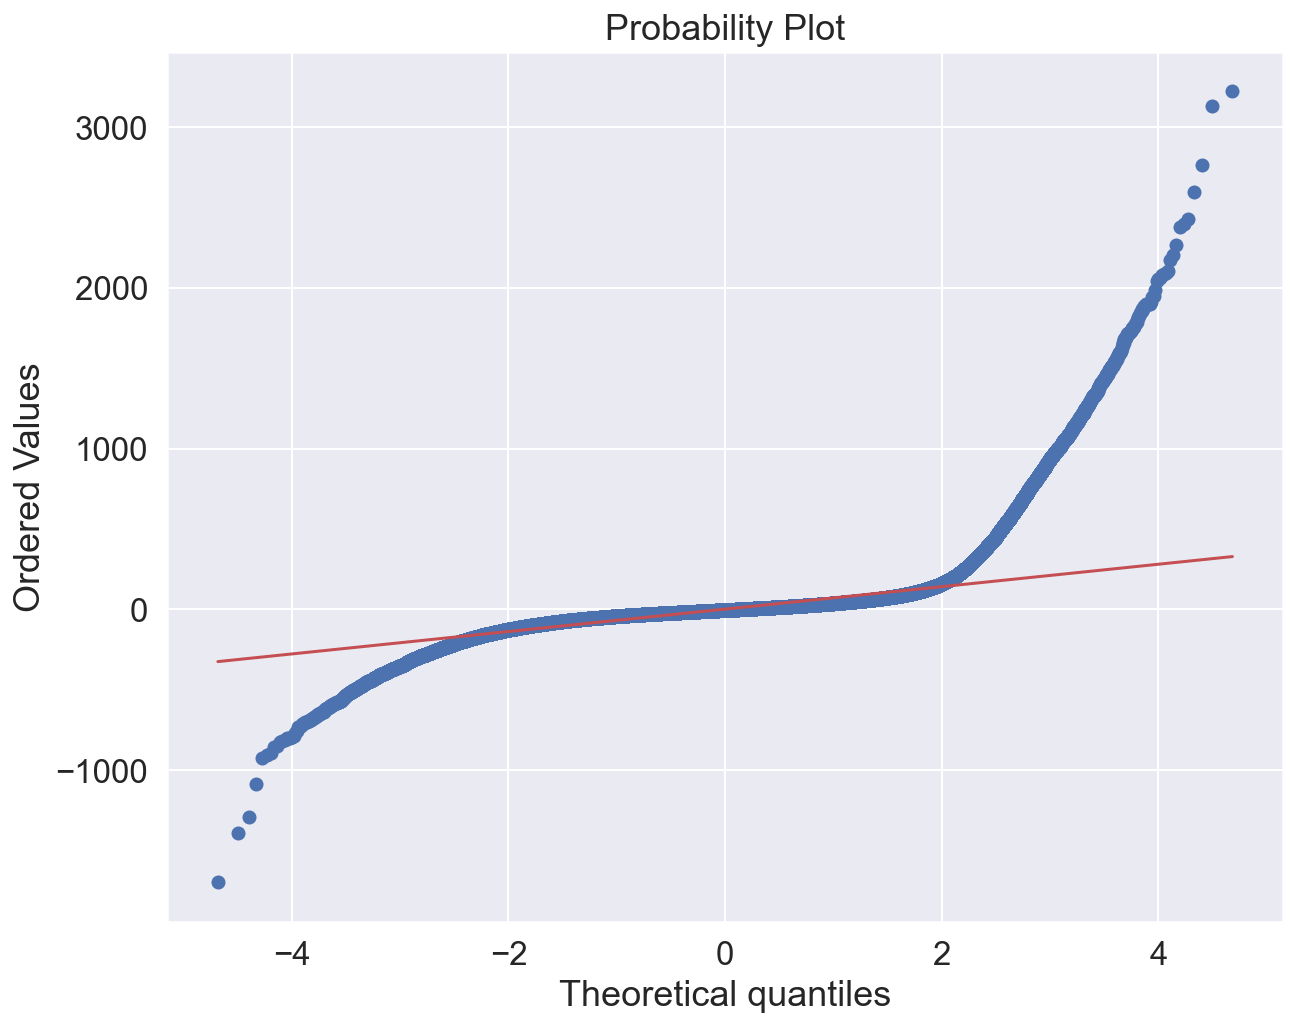

In [35]:
plt.figure(figsize=(10,8))
stats.probplot(residuals, plot=plt)
plt.show()

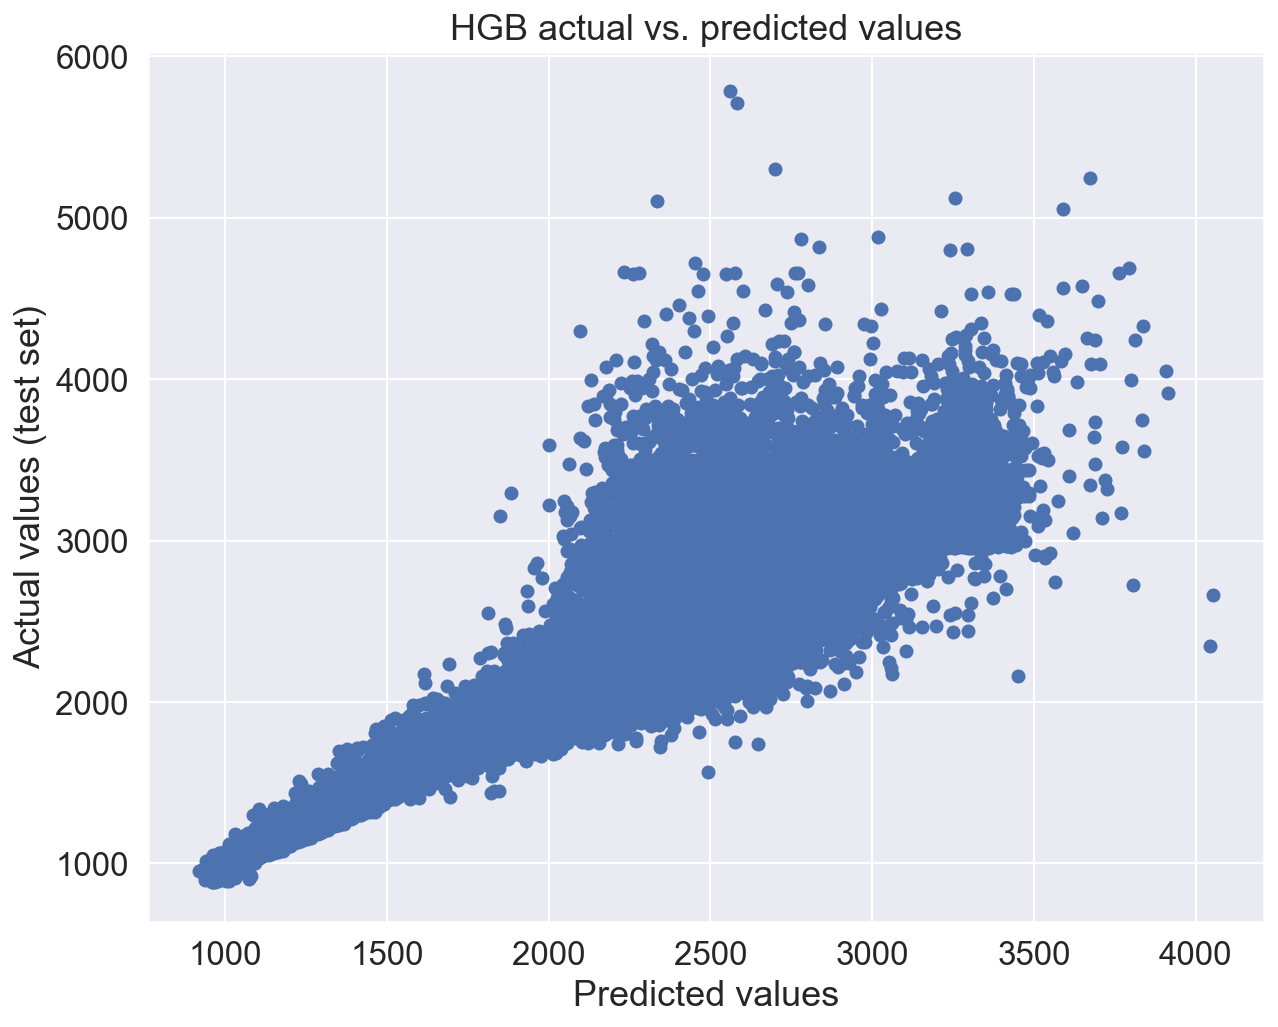

In [36]:
plt.figure(figsize=(10,8))
plt.scatter(x=preds_real, y=y_real)
plt.title('HGB actual vs. predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Actual values (test set)')
plt.show()

In [38]:
# This model does not provide feature importances so permutation importance is calculated as an approximation
result = permutation_importance(hgb, X_test, y_test, n_repeats=10,
                                random_state=random_state, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

Text(0.5, 1.0, 'Permutation Importance (test set)')

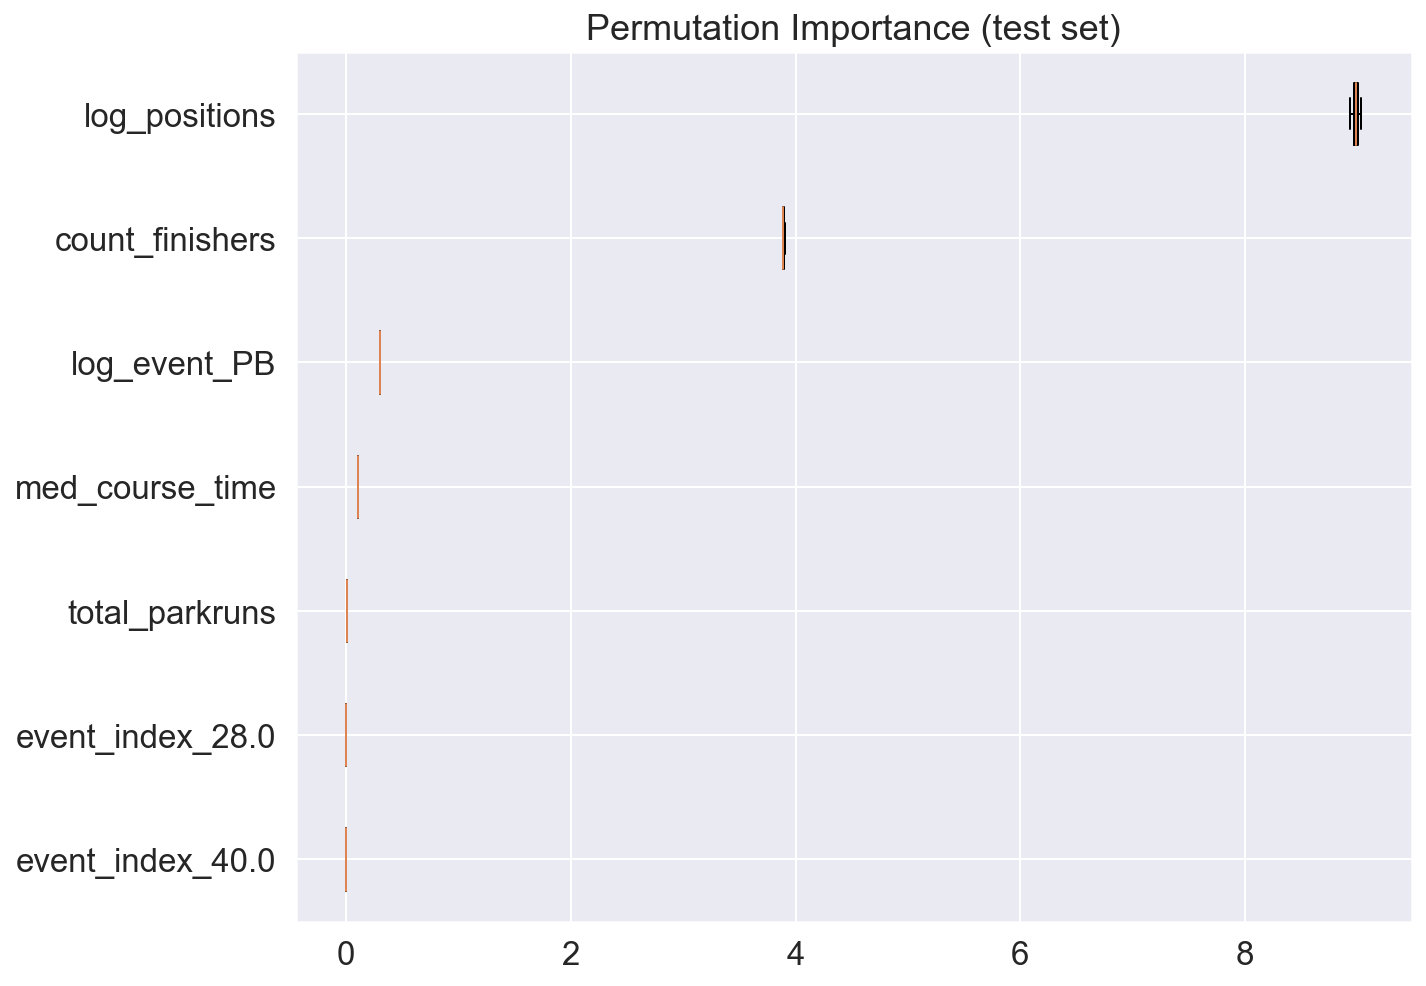

In [39]:
plt.figure(figsize=(10,8))
plt.boxplot(result.importances[sorted_idx[100:]].T,
            vert=False, labels=np.array(X_test.columns)[sorted_idx[100:]])
plt.title("Permutation Importance (test set)")

In [40]:
hgb_feat = pd.DataFrame(result.importances_mean, index=X_train.columns,
                       columns=['feature_importances'])

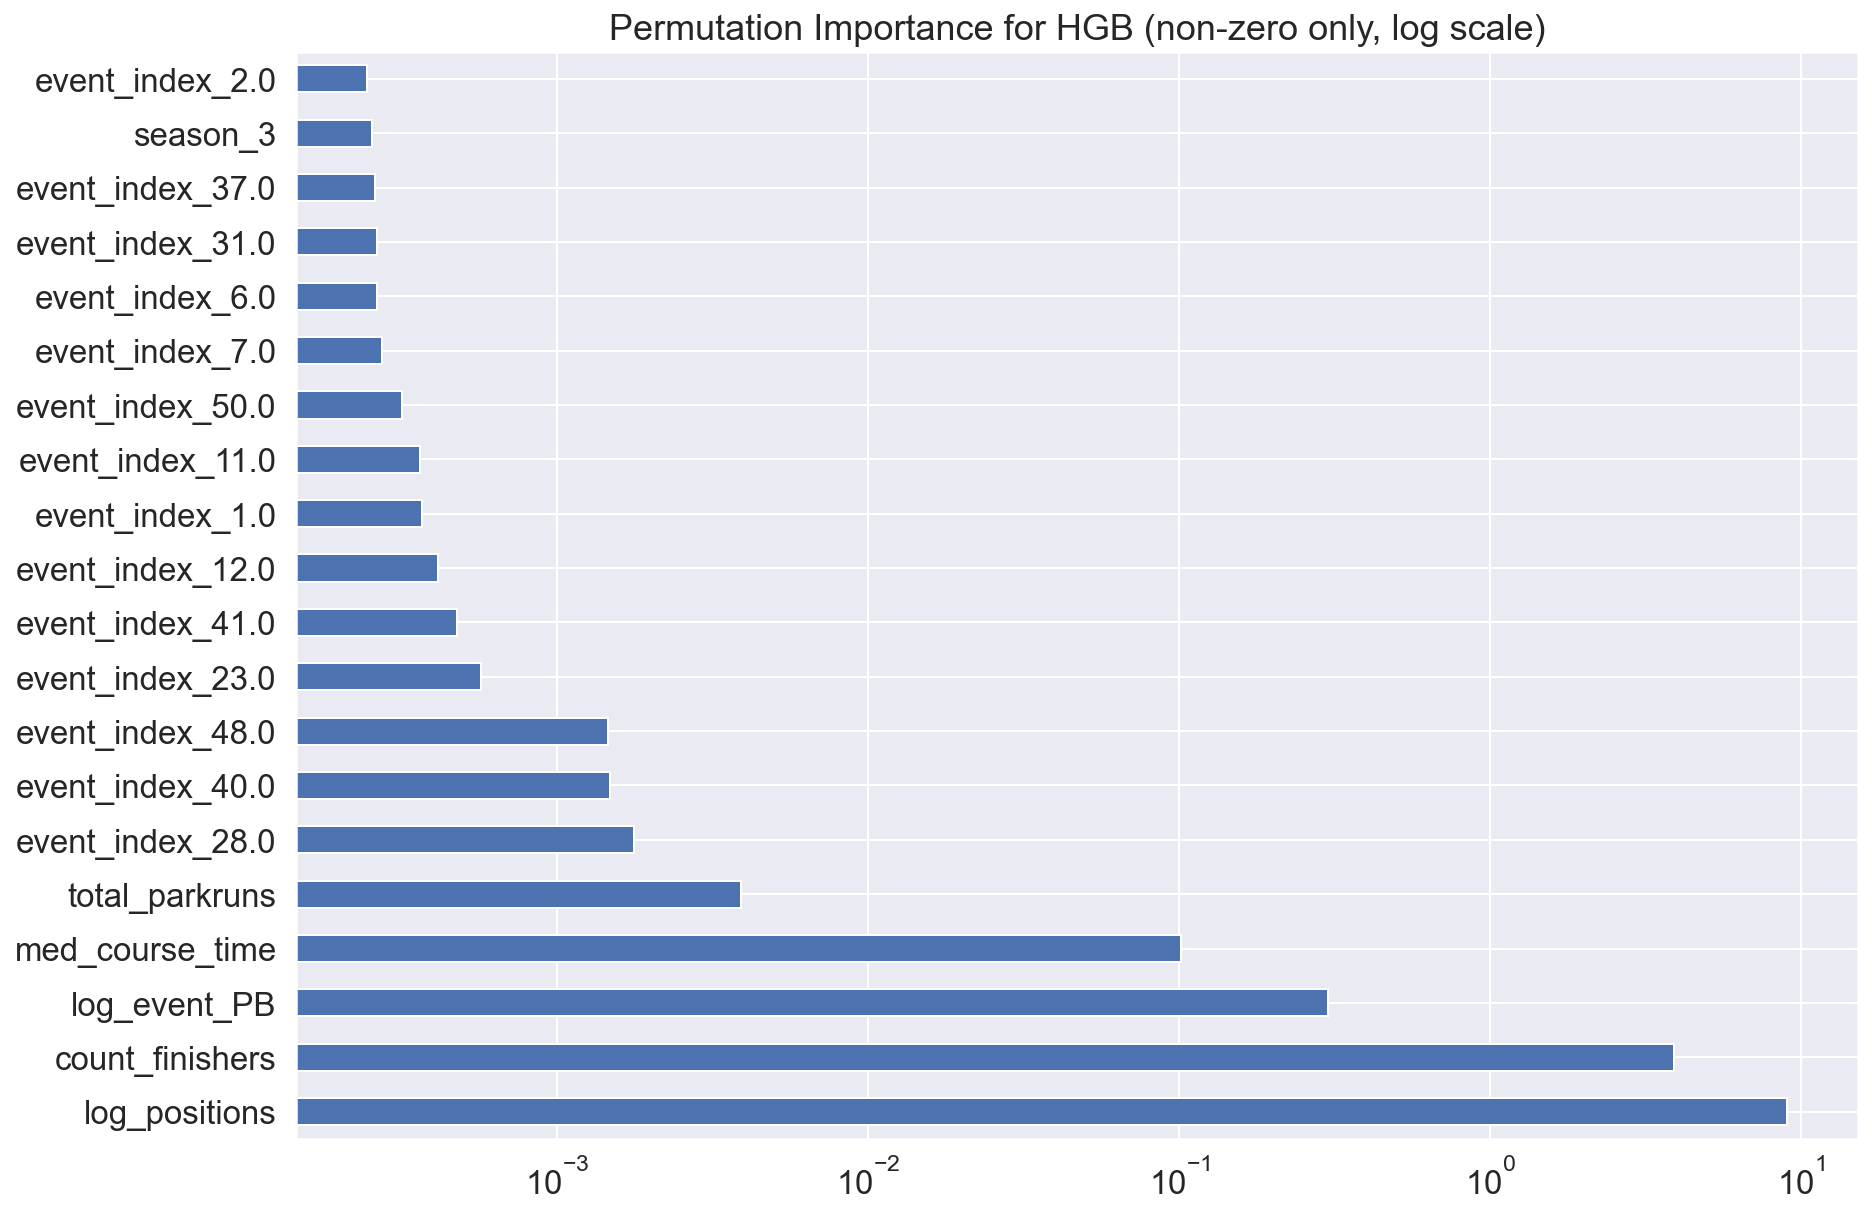

In [49]:
plt.figure(figsize=(14,10))
plt.title('Permutation Importance for HGB (non-zero only, log scale)')
hgb_feat[hgb_feat['feature_importances']!=0]['feature_importances'].sort_values(ascending=False).head(20).plot(
    kind='barh', log=True);

## Evaluation

- The scores have been improved through boosting
- We see from the residuals and probability plot that there is also improvement in predictions at faster times as well as possibly some improvement at slower times.
- Permutation importance is a different measure to feature importance but we see a similar set of key features with the highest importances
    - positions
    - count_finishers
    - event_PB
    - med_course_time
    - total_parkruns

## Predicting real events

- We can further evaluate the model performance by making prediction for a whole single event.
- The model will be retrained on all data except a single event, which is set aside as a test set for evaluation.
- Two events are chosen which represent different conditions
    - Wimbledon Common (index 50): muddy and wet, off-road conditions will result in slower times
    - Fulham Palace (index 17): tarmac path, dry course, will result in more consistent times

In [51]:
# Prepare full dataset for manual split
X_all = data[['event_index','total_parkruns', 'in_club', 'age_groups',
         'month', 'count_finishers', 'season', 'med_course_time', 'event_no']].copy()
X_all['log_positions'] = np.log(data.positions)
X_all['log_event_PB'] = np.log(data.event_PB)
X_all = pd.get_dummies(X_all, columns=regression_cat_cols, drop_first=True)
y_all = np.log(data.run_time)
X_all['y_all'] = y_all.copy()

### Wimbledon Common event 697

In [52]:
# split into train and test sets
X_test = X_all[(X_all['event_index_50.0']==1) & (X_all['event_no']==697)].copy()
y_test = X_test['y_all'].copy()
X_test = X_test.drop(columns=['y_all','event_no'])

X_train = X_all[(X_all['event_index_50.0']!=1) & (X_all['event_no']!=697)].copy()
y_train = X_train['y_all'].copy()
X_train = X_train.drop(columns=['y_all','event_no'])

In [53]:
# standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [54]:
# Fit and score model

hgb_W = HistGradientBoostingRegressor(
    max_iter=500,
    max_depth=5,
    learning_rate=0.1,
    random_state=random_state,
    validation_fraction=0.1,
    n_iter_no_change=20,
    monotonic_cst=mono_con)

hgb_W.fit(X_train, y_train)

print('Training score:', hgb_W.score(X_train, y_train))
print('Test score:', hgb_W.score(X_test, y_test))
hgb_W_scores = cross_val_score(hgb_W, X_train, y_train, cv=cv, n_jobs=-1)
print('Mean CV score:', np.mean(hgb_W_scores))
print('CV scores:', hgb_W_scores)

hgb_W_preds = hgb_W.predict(X_test)
print('MSE:', mean_squared_error(y_test, hgb_W_preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, hgb_W_preds)))
print('MAE:', mean_absolute_error(y_test, hgb_W_preds))

Training score: 0.9687293663325194
Test score: 0.7623390464979638
Mean CV score: 0.9680284902327502
CV scores: [0.96784858 0.96843863 0.96806353 0.96795954 0.96783218]
MSE: 0.013402911708420399
RMSE: 0.11577094500961975
MAE: 0.08641604999062488


In [55]:
# reverse transform to evaluate predictions
preds_real = np.exp(hgb_W_preds)
y_real = np.exp(y_test)
print('Test score after inverse transform:', r2_score(y_real, preds_real))
print('MSE:', mean_squared_error(y_real, preds_real))
print('RMSE:', np.sqrt(mean_squared_error(y_real, preds_real)))
print('MAE:', mean_absolute_error(y_real, preds_real))

Test score after inverse transform: 0.6531485552974731
MSE: 83207.05705220521
RMSE: 288.4563347409885
MAE: 172.4937934491853


In [68]:
residuals = y_real - preds_real

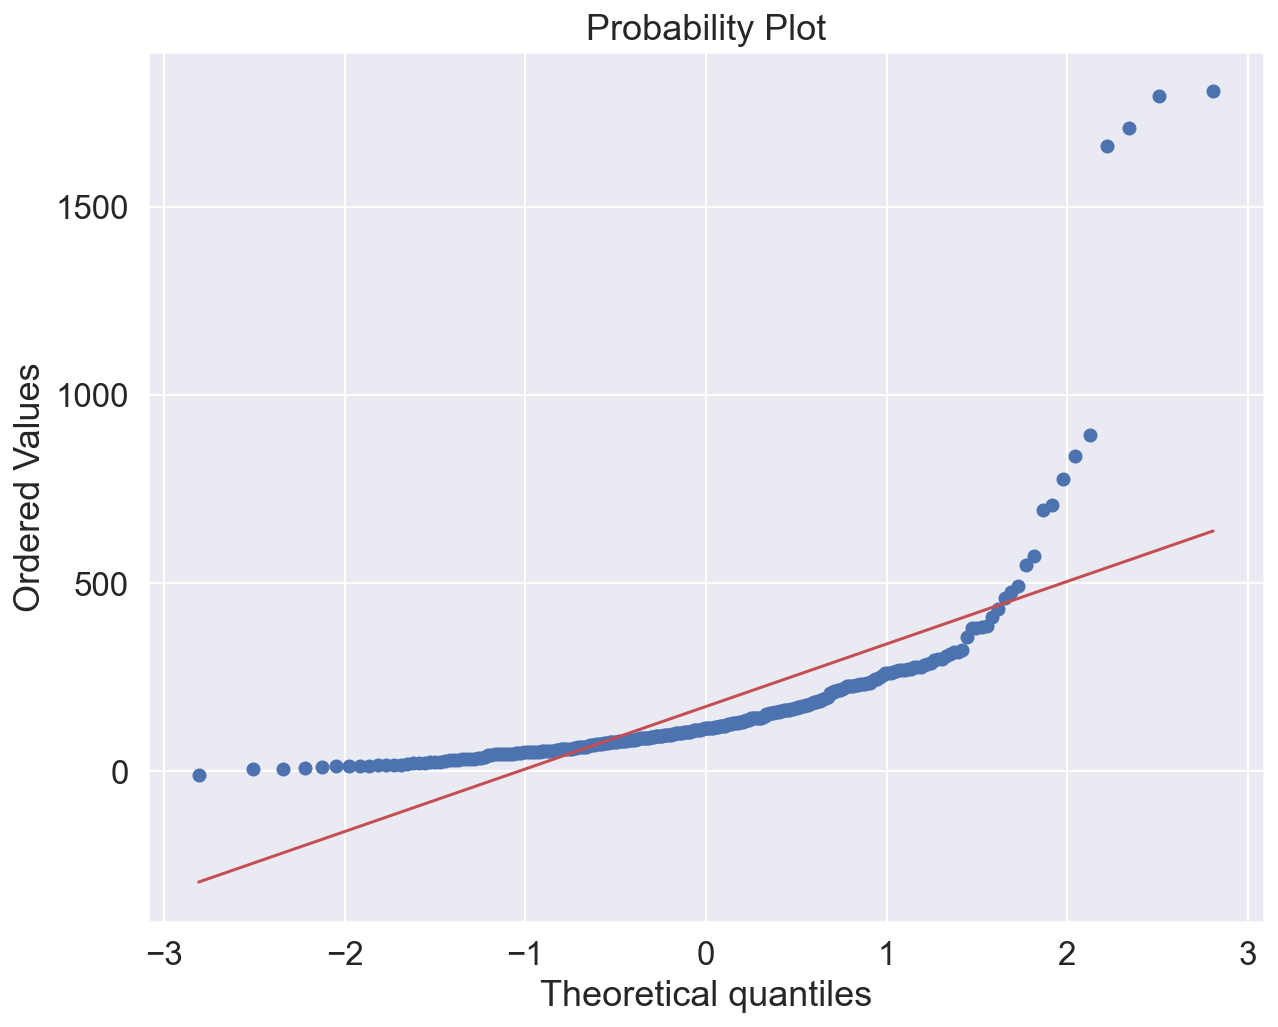

In [69]:
plt.figure(figsize=(10,8))
stats.probplot(residuals, plot=plt)
plt.show()

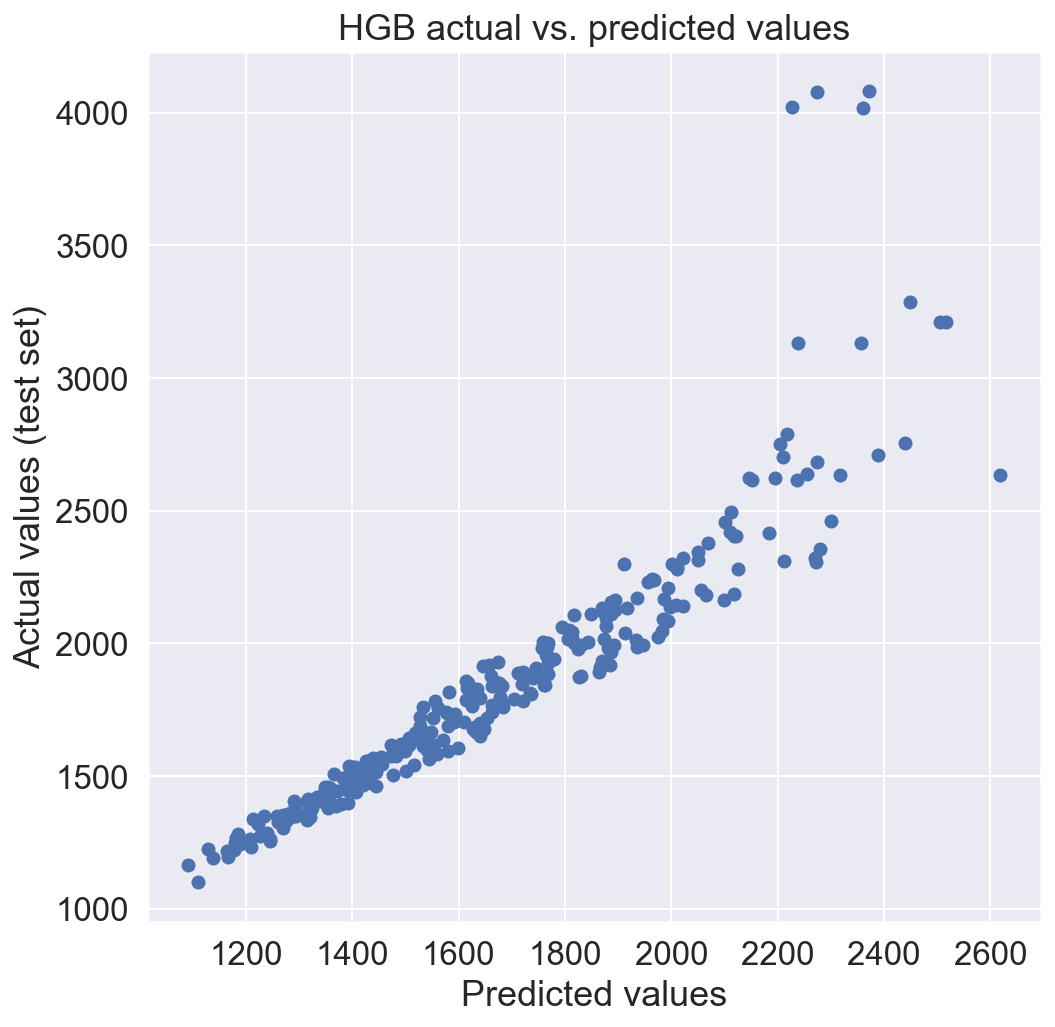

In [70]:
plt.figure(figsize=(8,8))
plt.scatter(x=preds_real, y=y_real)
plt.title('HGB actual vs. predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Actual values (test set)')
plt.show()

- For the Wimbledon event we see a lower score and higher error, as expected given the unusual conditions.
- The model consistently predicts faster times than observed.
- We can now reconstruct the results table to further evaluate the predictions.

In [71]:
wimbledon = data[(data.event_index==50) & (data.event_no==697)].copy()
wimbledon['model_results'] = preds_real
wimbledon['error'] = wimbledon.run_time - wimbledon.model_results

wimbledon = wimbledon[['positions', 'athlete_no', 'run_time', 'model_results', 'error',
                           'event_PB', 'total_parkruns', 'in_club', 'age_groups', 
                           'age_grades', 'is_PB']]

In [72]:
wimbledon.head(5)

,positions,athlete_no,run_time,model_results,error,event_PB,total_parkruns,in_club,age_groups,age_grades,is_PB
2317516,1.0,2014240.0,1100.0,1108.950462,-8.950462,1100.0,90.0,1.0,SM25-29,70.36,1
2317517,2.0,13534.0,1164.0,1091.885044,72.114956,1051.0,520.0,1.0,VM40-44,70.88,0
2317518,3.0,1295468.0,1189.0,1138.094484,50.905516,1153.0,16.0,0.0,SM20-24,65.10,0
2317519,4.0,2642790.0,1196.0,1165.632300,30.367700,1167.0,6.0,0.0,JM11-14,74.58,0
2317520,5.0,3932470.0,1216.0,1164.767638,51.232362,1157.0,70.0,1.0,SM30-34,64.14,0


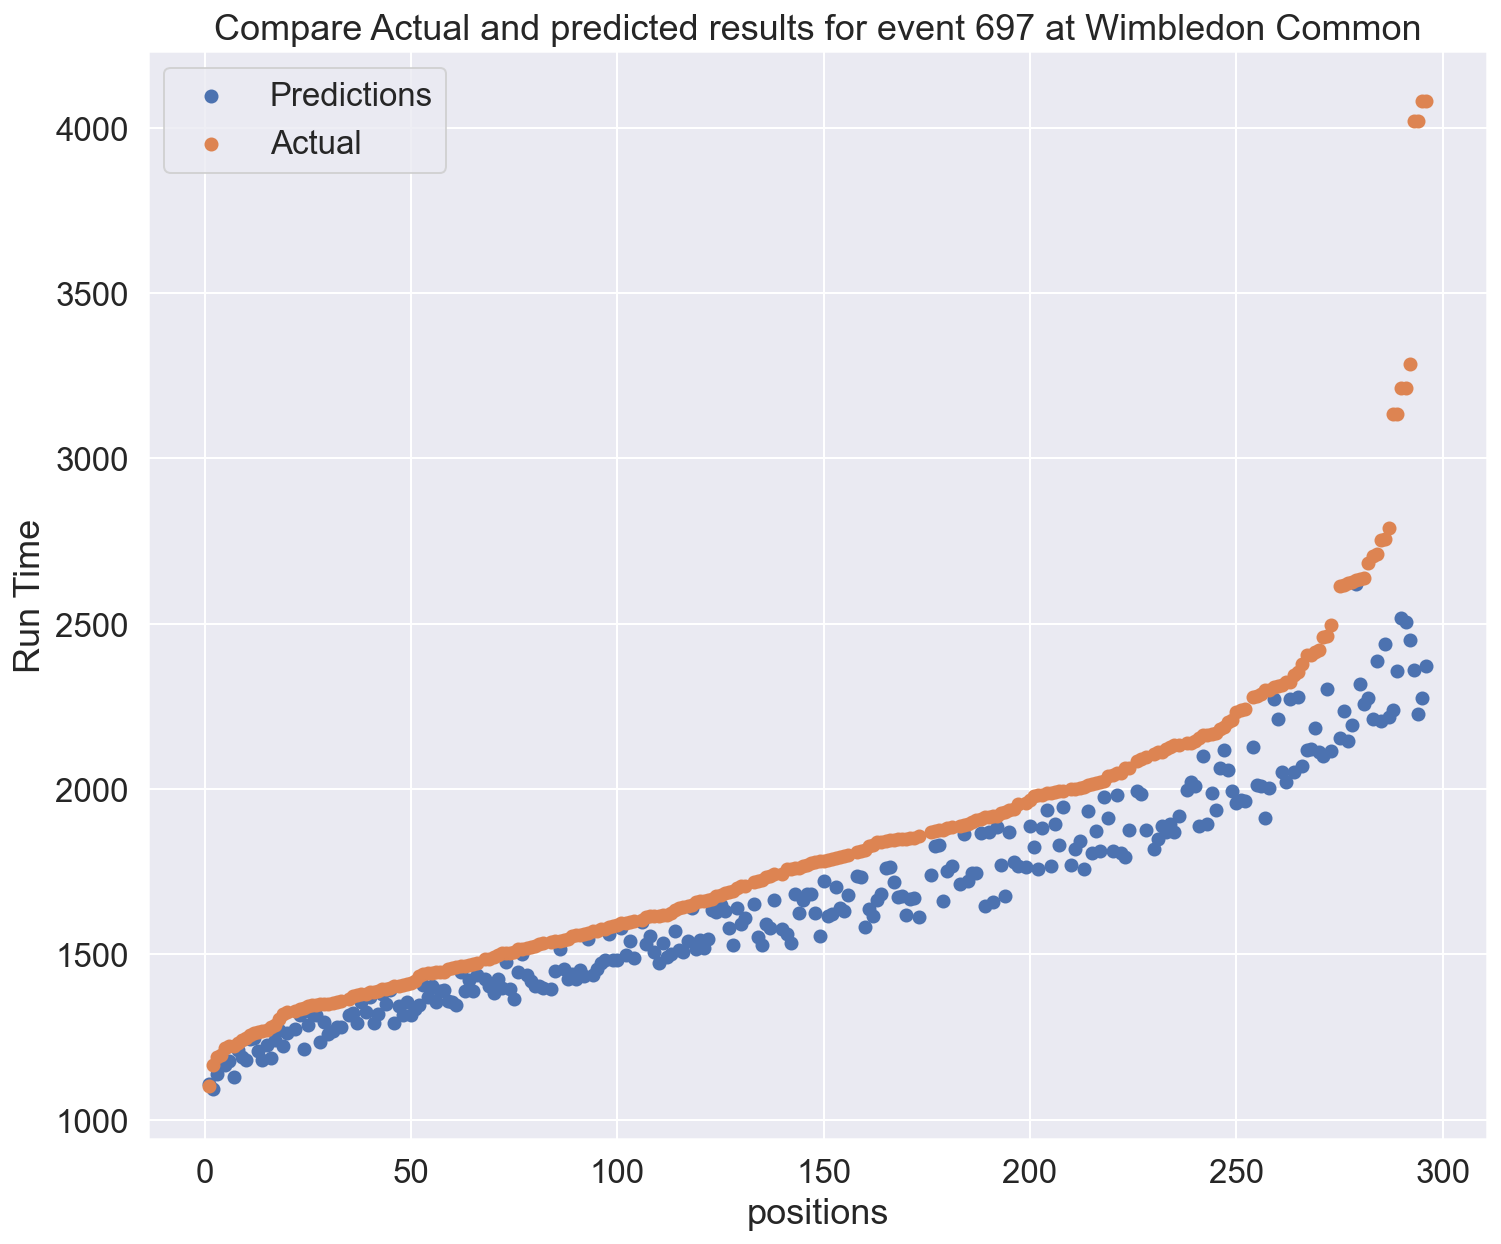

In [73]:
fig, ax = plt.subplots(figsize=(12,10))
ax = plt.scatter(data=wimbledon, x='positions', y='model_results')
ax = plt.scatter(data=wimbledon, x='positions', y='run_time')
plt.xlabel('positions')
plt.ylabel('Run Time')
plt.legend(['Predictions', 'Actual'])
plt.title('Compare Actual and predicted results for event 697 at Wimbledon Common')
plt.show()

- The results table and plot highlight the two main limitations of the model
    - Systematic underprediction of time due to the model not capturing the conditions at this event.
    - Predicted times do not increase monotonically with position, for example the runner in first place is predicted a slower finish time than the runner in second place.

## Fulham Palace event 335

In [74]:
# split into train and test sets
X_test = X_all[(X_all['event_index_17.0']==1) & (X_all['event_no']==335)].copy()
y_test = X_test['y_all'].copy()
X_test = X_test.drop(columns=['y_all','event_no'])

X_train = X_all[(X_all['event_index_17.0']!=1) & (X_all['event_no']!=335)].copy()
y_train = X_train['y_all'].copy()
X_train = X_train.drop(columns=['y_all','event_no'])

In [75]:
# standardise the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [76]:
# Fit and score model

hgb_F = HistGradientBoostingRegressor(
    max_iter=500,
    max_depth=5,
    learning_rate=0.1,
    random_state=random_state,
    validation_fraction=0.1,
    n_iter_no_change=20,
    monotonic_cst=mono_con)

hgb_F.fit(X_train, y_train)

print('Training score:', hgb_F.score(X_train, y_train))
print('Test score:', hgb_F.score(X_test, y_test))
hgb_F_scores = cross_val_score(hgb_F, X_train, y_train, cv=cv, n_jobs=-1)
print('Mean CV score:', np.mean(hgb_F_scores))
print('CV scores:', hgb_F_scores)

hgb_F_preds = hgb_F.predict(X_test)
print('MSE:', mean_squared_error(y_test, hgb_F_preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, hgb_F_preds)))
print('MAE:', mean_absolute_error(y_test, hgb_F_preds))

Training score: 0.968181217139024
Test score: 0.9316432597571244
Mean CV score: 0.9675563674246991
CV scores: [0.96740604 0.96702711 0.96780176 0.96789273 0.9676542 ]
MSE: 0.0032383697752208923
RMSE: 0.05690667601627152
MAE: 0.016473866668693424


In [77]:
# reverse transform to evaluate predictions
preds_real = np.exp(hgb_F_preds)
y_real = np.exp(y_test)
print('Test score after inverse transform:', r2_score(y_real, preds_real))
print('MSE:', mean_squared_error(y_real, preds_real))
print('RMSE:', np.sqrt(mean_squared_error(y_real, preds_real)))
print('MAE:', mean_absolute_error(y_real, preds_real))

Test score after inverse transform: 0.8004131758983621
MSE: 37502.19181016634
RMSE: 193.65482645719507
MAE: 36.88046727150911


In [78]:
residuals = y_real - preds_real

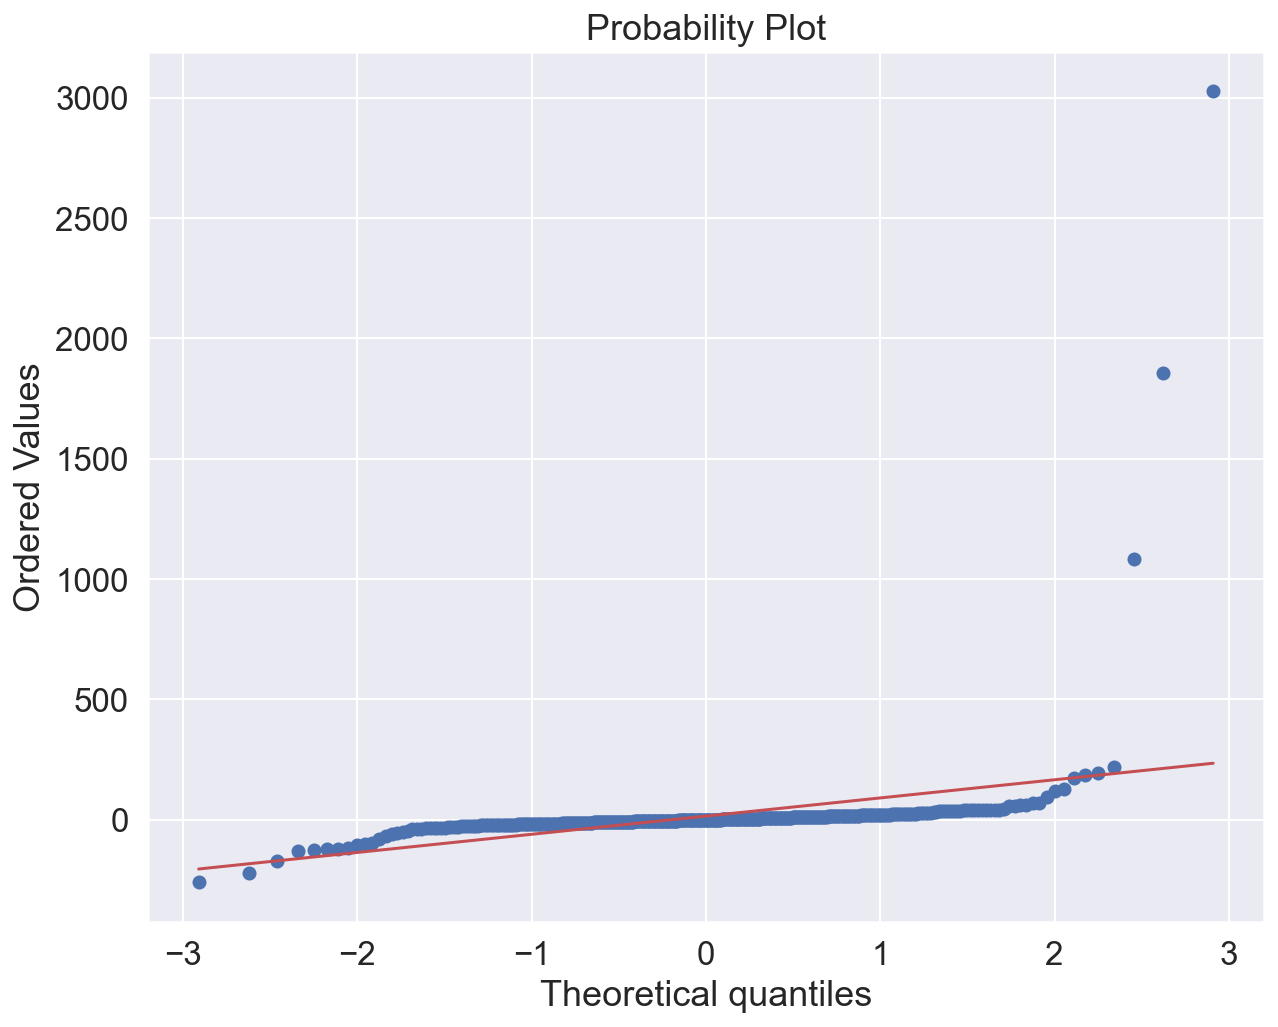

In [79]:
plt.figure(figsize=(10,8))
stats.probplot(residuals, plot=plt)
plt.show()

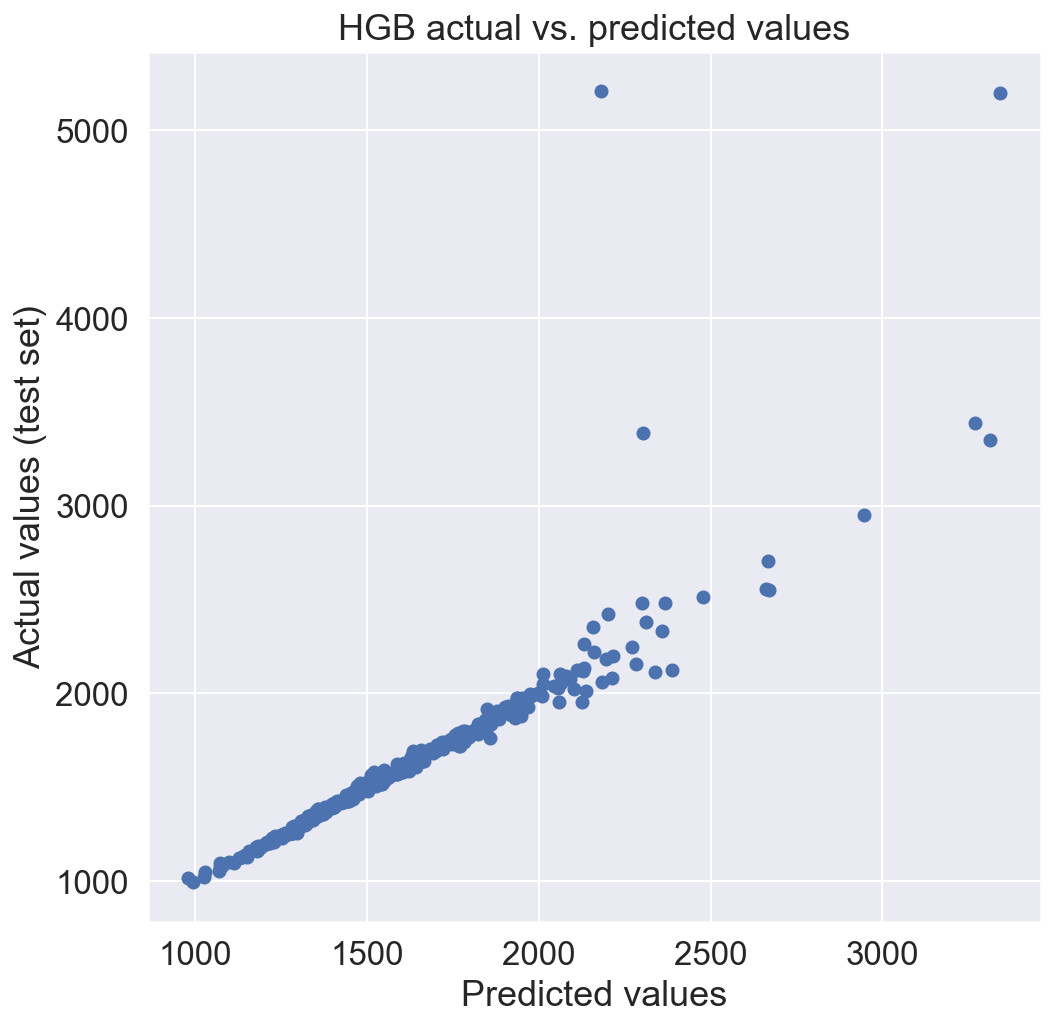

In [80]:
plt.figure(figsize=(8,8))
plt.scatter(x=preds_real, y=y_real)
plt.title('HGB actual vs. predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Actual values (test set)')
plt.show()

- The model is much more succesful for the Fulham event than the Wimbledon event, which significantly higher score and lower error.
- Errors are still more significant at slower finish times.
- We can reconstruct the results and compare in the same way

In [81]:
fulham = data[(data.event_index==17) & (data.event_no==335)].copy()
fulham['model_results'] = preds_real
fulham['error'] = fulham.run_time - fulham.model_results

fulham = fulham[['positions', 'athlete_no', 'run_time', 'model_results', 'error',
                           'event_PB', 'total_parkruns', 'in_club', 'age_groups', 
                           'age_grades', 'is_PB']]

In [82]:
fulham.head(5)

,positions,athlete_no,run_time,model_results,error,event_PB,total_parkruns,in_club,age_groups,age_grades,is_PB
1032502,1.0,204718.0,995.0,993.326377,1.673623,984.0,53.0,1.0,SM30-34,78.69,0
1032503,2.0,6514091.0,1014.0,980.498642,33.501358,1014.0,3.0,0.0,SM25-29,76.33,1
1032504,3.0,39159.0,1023.0,1025.660469,-2.660469,977.0,394.0,1.0,VM35-39,77.81,0
1032505,4.0,4422789.0,1046.0,1028.082145,17.917855,1007.0,21.0,1.0,SM30-34,74.57,0
1032506,5.0,190979.0,1052.0,1070.468190,-18.468190,1052.0,65.0,0.0,SM25-29,73.57,1


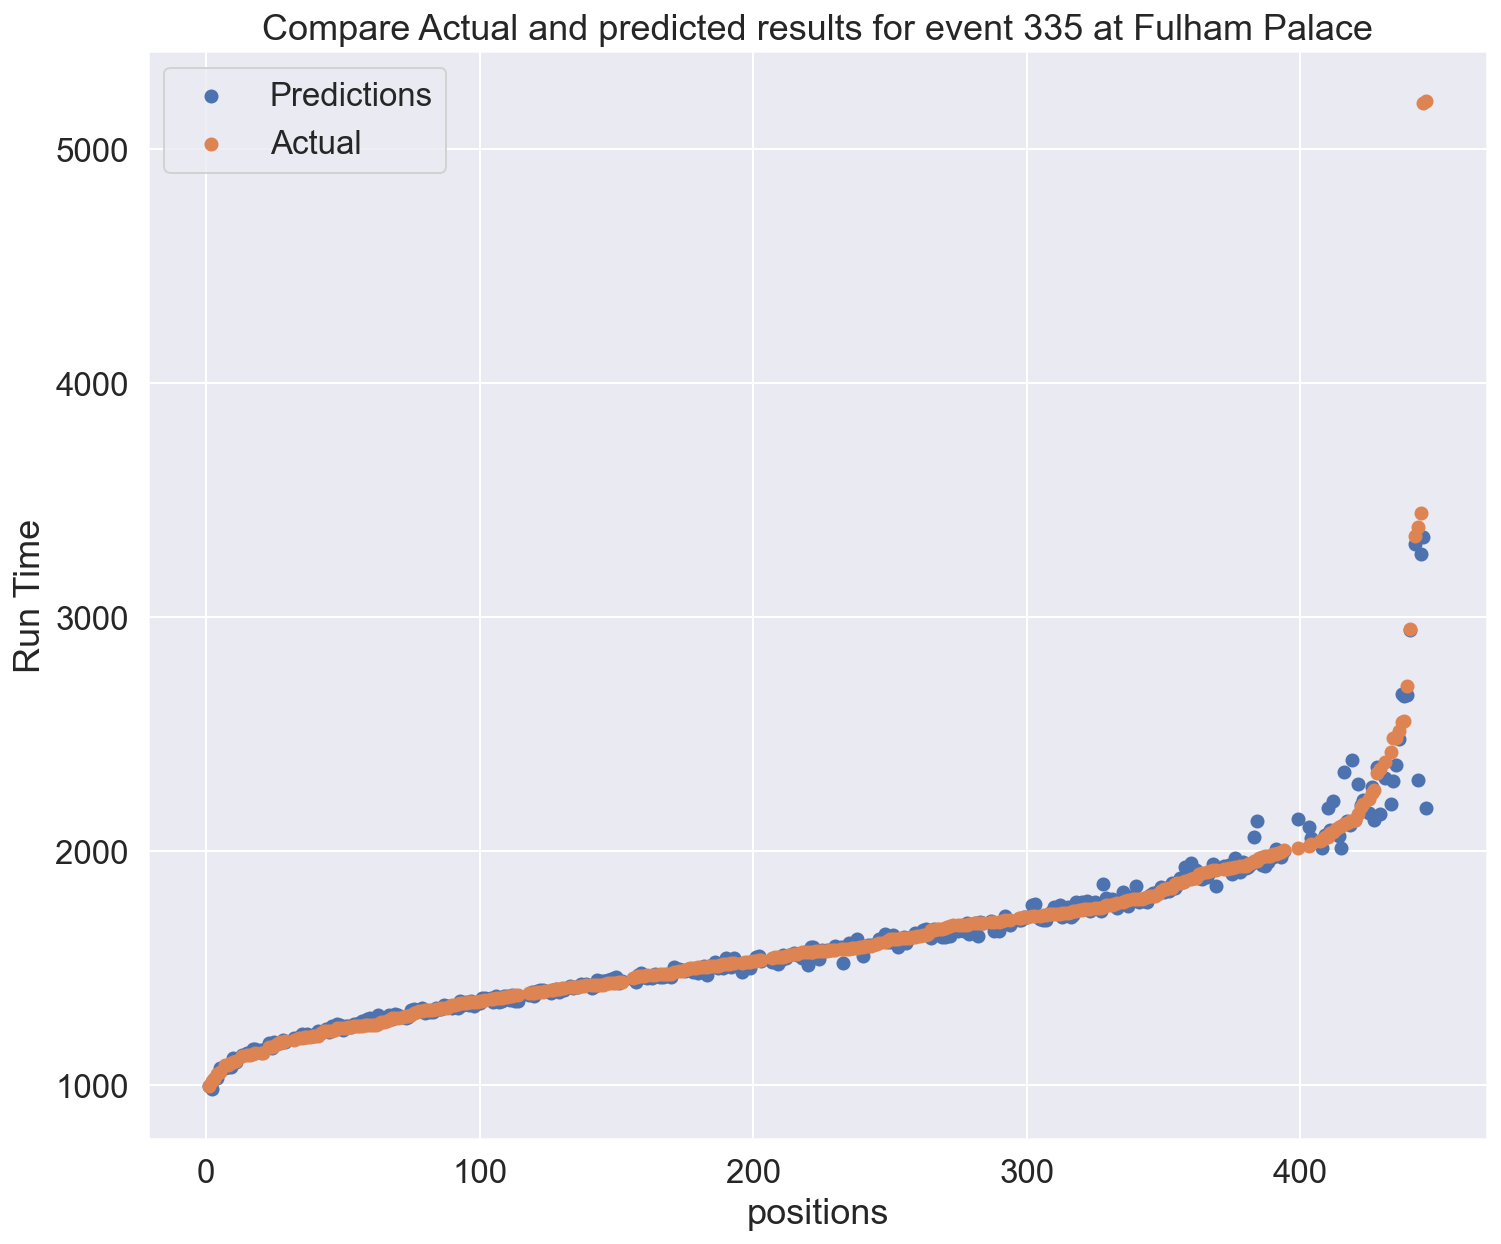

In [83]:
fig, ax = plt.subplots(figsize=(12,10))
ax = plt.scatter(data=fulham, x='positions', y='model_results')
ax = plt.scatter(data=fulham, x='positions', y='run_time')
plt.xlabel('positions')
plt.ylabel('Run Time')
plt.legend(['Predictions', 'Actual'])
plt.title('Compare Actual and predicted results for event 335 at Fulham Palace')
plt.show()

- The model is clearly performing better for this event, which has much less variable conditions for running.
    - The residuals are more normally distributed across all finish times
    - The problem of predicted times not increasing monotonically with positions remains, but it is less pronouced.

### See README for final evaluation and conclusions